In [3]:
# Imports for model building and classification
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Load the breast cancer dataset
breast_cancer_data = load_breast_cancer()

# Read in the project3 dataset
project3_data = pd.read_csv("Project3_Dataset.csv")

# 1. Classification on the Breast Cancer dataset #
## Task 1: Building the Best Baseline Model ##

Baseline Classifier Accuracies:
Logistic Regression: Test Accuracy = 97.66%, Cross-Validation Accuracy = 94.72%
KNN: Test Accuracy = 95.91%, Cross-Validation Accuracy = 91.45%
ANN: Test Accuracy = 95.91%, Cross-Validation Accuracy = 92.96%
Decision Tree: Test Accuracy = 94.15%, Cross-Validation Accuracy = 90.96%
Naive Bayes: Test Accuracy = 94.15%, Cross-Validation Accuracy = 93.72%
SVM: Test Accuracy = 93.57%, Cross-Validation Accuracy = 89.43%

Best Classifier is Logistic Regression with an accuracy of 97.66%

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

   malignant       0.97      0.97      0.97        63
      benign       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



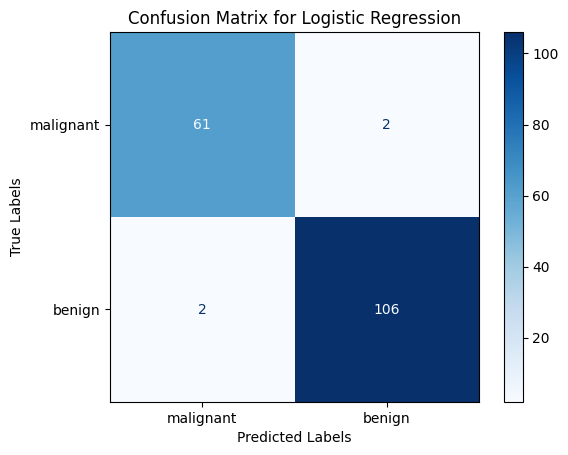

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 97.74%

Updated Classification Report for Hypertuned Logistic Regression:

              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99        63
      benign       0.99      1.00      1.00       108

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

Updated Accuracy Score for Logistic Regression: 99.42%



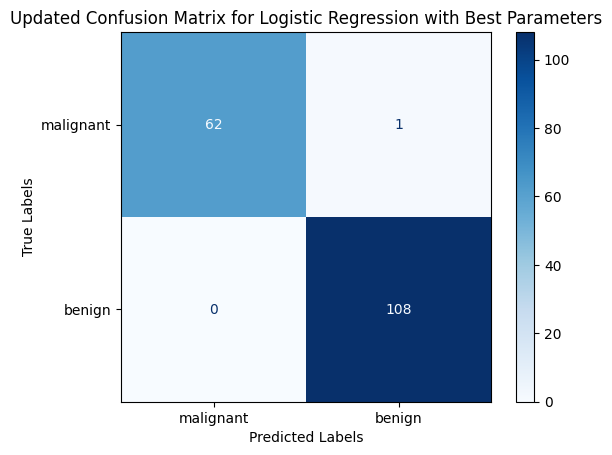

In [4]:
# Split the data into features (X) and target (y)
X = breast_cancer_data.data
y = breast_cancer_data.target

# Split into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a dictionary of classifiers for testing (max_iter values set to avoid convergence failure warnings upon hitting the default max iterations)
baseline_classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'ANN': MLPClassifier(random_state=42, max_iter=5000),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000)
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in baseline_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
   
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    
    # Store model name, test accuracy, and cross-validation accuracy
    results.append((name, accuracy, mean_cv_score))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_baseline_classifier_name, best_baseline_classifier_accuracy, best_baseline_cv_accuracy = results[0]
best_baseline_classifier = baseline_classifiers[best_baseline_classifier_name]

# Generate predictions using the best classifier
y_pred = best_baseline_classifier.predict(X_test)

# Display the classification results 
print("Baseline Classifier Accuracies:")
for name, test_acc, cv_acc in results:
    print(f"{name}: Test Accuracy = {test_acc * 100:.2f}%, Cross-Validation Accuracy = {cv_acc * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_baseline_classifier_name} with an accuracy of {best_baseline_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred, target_names=breast_cancer_data.target_names))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=breast_cancer_data.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_baseline_classifier_name}")
plt.show()

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
baseline_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers
    'penalty': ['l2']
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
baseline_grid_search = GridSearchCV(estimator=best_baseline_classifier, param_grid=baseline_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
baseline_grid_search.fit(X_train_scaled, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_baseline_params = baseline_grid_search.best_params_
best_baseline_model = baseline_grid_search.best_estimator_

print(f"Best Parameters: {best_baseline_params}")
print(f"Best Cross-Validation Accuracy: {baseline_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_baseline_model.predict(X_test_scaled)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, target_names=breast_cancer_data.target_names))
print(f"Updated Accuracy Score for {best_baseline_classifier_name}: {best_baseline_model.score(X_test_scaled, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated, display_labels=breast_cancer_data.target_names)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_baseline_classifier_name} with Best Parameters")
plt.show()




## Task 2: Building the Best Ensemble Model ##

Esemble Classifier Accuracies:
RandomForest: Test Accuracy = 97.08%, Cross-Validation Accuracy = 94.97%
AdaBoost: Test Accuracy = 97.08%, Cross-Validation Accuracy = 97.49%
GradientBoosting: Test Accuracy = 95.91%, Cross-Validation Accuracy = 95.48%
Bagging: Test Accuracy = 94.74%, Cross-Validation Accuracy = 93.46%

Best Classifier is RandomForest with an accuracy of 97.08%

Classification Report for RandomForest:

              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



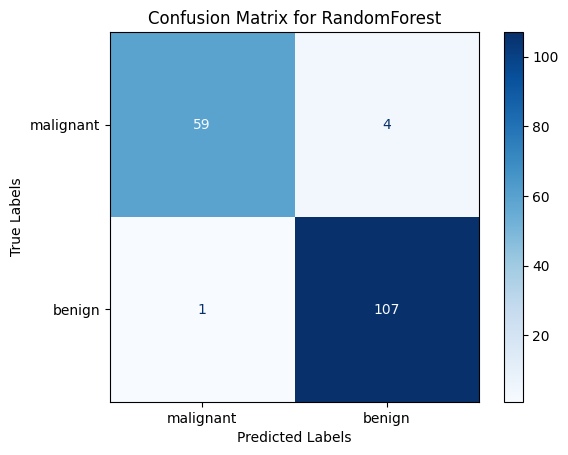

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 400}
Best Cross-Validation Accuracy: 95.72%

Updated Classification Report for Hypertuned RandomForest:

              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        63
      benign       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171

Updated Accuracy Score for RandomForest: 97.08%



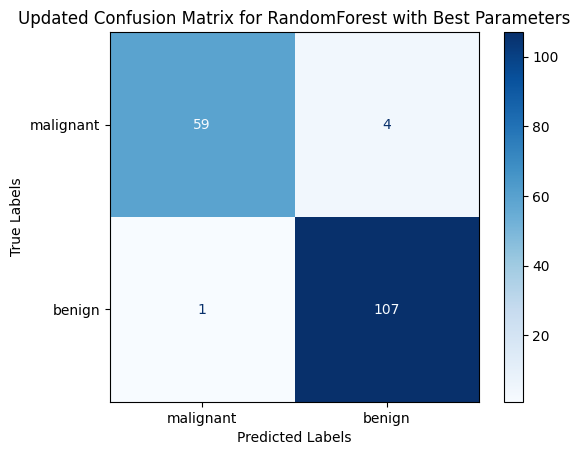

Best Parameters: {'learning_rate': 1, 'n_estimators': 50}
Best Cross-Validation Accuracy: 97.49%

Updated Classification Report for Hypertuned AdaBoost:

              precision    recall  f1-score   support

   malignant       0.95      0.97      0.96        63
      benign       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Updated accuracy for AdaBoost: 97.08%



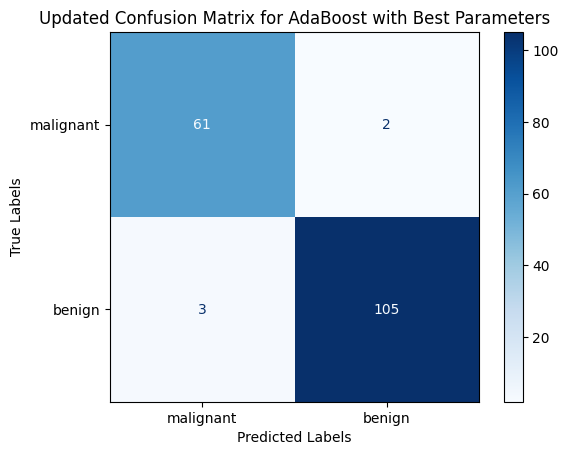

In [5]:
# Split into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a dictionary of classifiers for testing (algorithm="SAMME.R" prevents deprication warning)
ensemble_classifiers = {
    'Bagging': BaggingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in ensemble_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
     # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    
    # Store model name, test accuracy, and cross-validation accuracy
    results.append((name, accuracy, mean_cv_score))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_ensemble_classifier_name, best_ensemble_classifier_accuracy, best_ensemble_cv_accuracy = results[0]
best_ensemble_classifier = ensemble_classifiers[best_ensemble_classifier_name]

# Generate predictions using the best classifier
y_pred = best_ensemble_classifier.predict(X_test)

# Display the classification results 
print("Esemble Classifier Accuracies:")
for name, test_acc, cv_acc in results:
    print(f"{name}: Test Accuracy = {test_acc * 100:.2f}%, Cross-Validation Accuracy = {cv_acc * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_ensemble_classifier_name} with an accuracy of {best_ensemble_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred, target_names=breast_cancer_data.target_names))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=breast_cancer_data.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_ensemble_classifier_name}")
plt.show()

# Define the parameter grid
ensemble_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
ensemble_grid_search = GridSearchCV(estimator=best_ensemble_classifier, param_grid=ensemble_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
ensemble_grid_search.fit(X_train, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_params = ensemble_grid_search.best_params_
best_ensemble_model = ensemble_grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {ensemble_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_ensemble_model.predict(X_test)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, target_names=breast_cancer_data.target_names))
print(f"Updated Accuracy Score for {best_ensemble_classifier_name}: {best_ensemble_model.score(X_test, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated, display_labels=breast_cancer_data.target_names)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_ensemble_classifier_name} with Best Parameters")
plt.show()

# Define the parameter grid
ada_param_grid = {
    'n_estimators': [25, 50, 100], 
    'learning_rate': [0.01, 0.1, 1, 10],
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
ensemble_grid_search = GridSearchCV(estimator=ensemble_classifiers["AdaBoost"], param_grid=ada_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
ensemble_grid_search.fit(X_train, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_params = ensemble_grid_search.best_params_
best_ensemble_model = ensemble_grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {ensemble_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_ensemble_model.predict(X_test)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned AdaBoost:\n")
print(classification_report(y_test, y_pred_updated, target_names=breast_cancer_data.target_names))
print(f"Updated accuracy for AdaBoost: {best_ensemble_model.score(X_test, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated, display_labels=breast_cancer_data.target_names)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for AdaBoost with Best Parameters")
plt.show()




# 2. Classification on the attached dataset (Project3_Dataset.csv) #
## Task 1: Normalizing the Features ##

In [6]:
# Separate features (columns 1 to 65) and labels (column 66)
X = project3_data.iloc[:, :-1].values  # Features (columns 1 to 65)
y = project3_data.iloc[:, -1].values   # Labels (column 66)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

## Task 2: Building the Best Baseline Model

Baseline Classifier Accuracies:
Logistic Regression: Test Accuracy = 72.50%, Cross-Validation Accuracy = 64.05%
Naive Bayes: Test Accuracy = 65.00%, Cross-Validation Accuracy = 55.08%
ANN: Test Accuracy = 65.00%, Cross-Validation Accuracy = 57.74%
SVM: Test Accuracy = 55.00%, Cross-Validation Accuracy = 51.27%
KNN: Test Accuracy = 50.00%, Cross-Validation Accuracy = 49.31%
Decision Tree: Test Accuracy = 42.50%, Cross-Validation Accuracy = 46.79%

Best Classifier is Logistic Regression with an accuracy of 72.50%

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           2       1.00      0.75      0.86         4
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.50      0.50      0.50         2
           7       0.75      1.00      0.86         3
           8       1.00      0.50      0.67         4
 

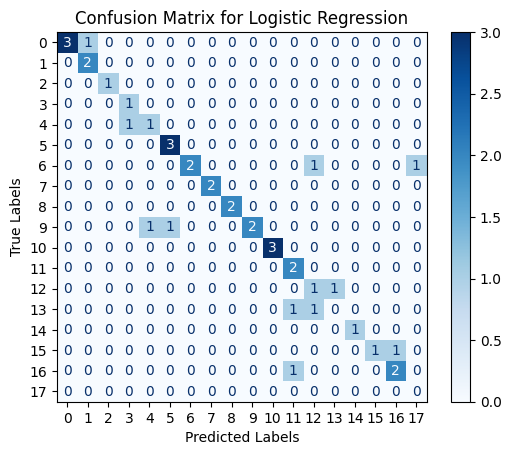

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Accuracy: 64.72%

Updated Classification Report for Hypertuned Logistic Regression:

              precision    recall  f1-score   support

           2       1.00      0.75      0.86         4
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.50      0.50      0.50         2
           7       0.75      1.00      0.86         3
           8       1.00      0.50      0.67         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         4
          13       1.00      1.00      1.00         3
          14       0.50      1.00      0.67         2
          15       0.33      0.50      0.40         2
          16       0.00      0.00      0.00         2
          17       1.

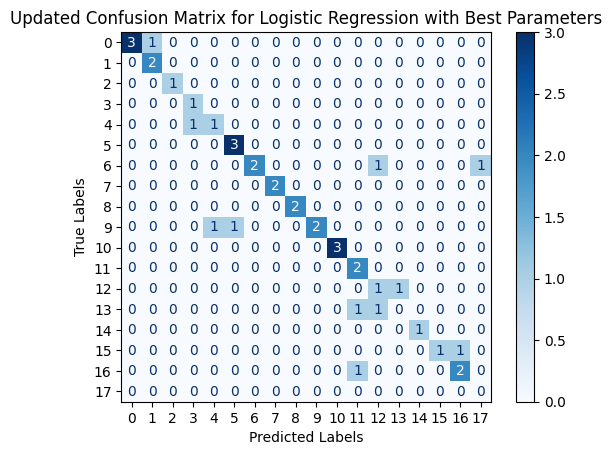

In [ ]:
# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Define a dictionary of classifiers for testing (max_iter values set to avoid convergence failure warnings upon hitting the default max iterations)
baseline_classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'ANN': MLPClassifier(random_state=42, max_iter=5000),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000)
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in baseline_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    
    # Store model name, test accuracy, and cross-validation accuracy
    results.append((name, accuracy, mean_cv_score))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_baseline_classifier_name, best_baseline_classifier_accuracy, best_baseline_cv_accuracy = results[0]
best_baseline_classifier = baseline_classifiers[best_baseline_classifier_name]

# Generate predictions using the best classifier
y_pred = best_baseline_classifier.predict(X_test)

# Display baseline classifier accuracies
print("Baseline Classifier Accuracies:")
for name, test_acc, cv_acc in results:
    print(f"{name}: Test Accuracy = {test_acc * 100:.2f}%, Cross-Validation Accuracy = {cv_acc * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_baseline_classifier_name} with an accuracy of {best_baseline_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_baseline_classifier_name}")
plt.show()

# Define the parameter grid
baseline_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers
    'penalty': ['l2']
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
baseline_grid_search = GridSearchCV(estimator=best_baseline_classifier, param_grid=baseline_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
baseline_grid_search.fit(X_train, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_baseline_params = baseline_grid_search.best_params_
best_baseline_model = baseline_grid_search.best_estimator_

print(f"Best Parameters: {best_baseline_params}")
print(f"Best Cross-Validation Accuracy: {baseline_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_baseline_model.predict(X_test)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_baseline_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, zero_division=0))
print(f"Updated accuracy for {best_baseline_classifier_name}: {best_baseline_model.score(X_test, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_baseline_classifier_name} with Best Parameters")
plt.show()



## Task 3: Building the Best Ensemble Model ##

Esemble Classifier Accuracies:
RandomForest: Test Accuracy = 70.00%, Cross-Validation Accuracy = 62.84%
Bagging: Test Accuracy = 57.50%, Cross-Validation Accuracy = 53.87%
GradientBoosting: Test Accuracy = 57.50%, Cross-Validation Accuracy = 37.84%
AdaBoost: Test Accuracy = 17.50%, Cross-Validation Accuracy = 17.94%

Best Classifier is RandomForest with an accuracy of 70.00%

Classification Report for RandomForest:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         2
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         1
           6       0.67      1.00      0.80         2
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         4
           9       0.00      0.00      0.00         2
          10       1.00      1.00      

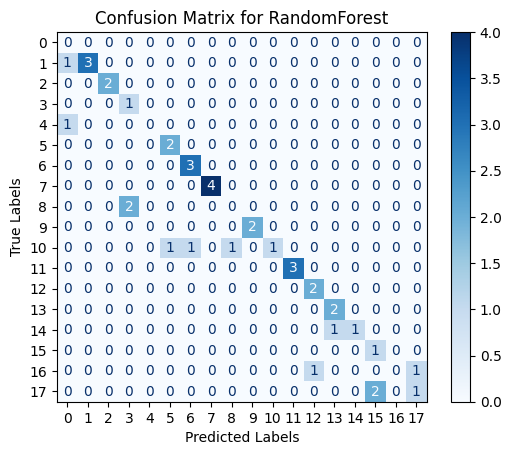

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Best Cross-Validation Accuracy: 63.45%

Updated Classification Report for Hypertuned RandomForest:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         2
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         1
           6       0.67      1.00      0.80         2
           7       0.50      0.33      0.40         3
           8       1.00      1.00      1.00         4
           9       0.00      0.00      0.00         2
          10       0.50      1.00      0.67         2
          12       0.67      0.50      0.57         4
          13       1.00      1.00      1.00         3
          14       0.50      1.00      0.67         2
          15       1.00      1.00      1.00         2
         

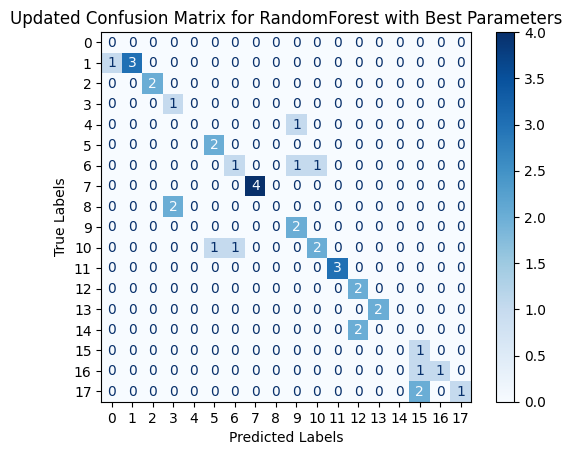

In [ ]:
# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Define a dictionary of classifiers for testing (algorithm="SAMME.R" prevents deprication warning)
ensemble_classifiers = {
    'Bagging': BaggingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm="SAMME", random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
}
results = []  # Dictionary to store results

# Loop through classifiers
for name, model in ensemble_classifiers.items():
    # Train and test (calculate accuracy) the model and store it in the results tuple
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    
    # Store model name, test accuracy, and cross-validation accuracy
    results.append((name, accuracy, mean_cv_score))

# Sort results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Get the highest scoring classifier
best_ensemble_classifier_name, best_ensemble_classifier_accuracy, best_ensemble_cv_accuracy = results[0]
best_ensemble_classifier = ensemble_classifiers[best_ensemble_classifier_name]

# Generate predictions using the best classifier
y_pred = best_ensemble_classifier.predict(X_test)

# Display the classification results 
print("Esemble Classifier Accuracies:")
for name, test_acc, cv_acc in results:
    print(f"{name}: Test Accuracy = {test_acc * 100:.2f}%, Cross-Validation Accuracy = {cv_acc * 100:.2f}%")

# Display the best classifier
print(f"\nBest Classifier is {best_ensemble_classifier_name} with an accuracy of {best_ensemble_classifier_accuracy * 100:.2f}%")

# Display classification report for the best model
print(f"\nClassification Report for {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Compute and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix for {best_ensemble_classifier_name}")
plt.show()

# Define the parameter grid
ensemble_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
}

# Create the GridSearchCV object and hypertune the paramters using all available threads
ensemble_grid_search = GridSearchCV(estimator=best_ensemble_classifier, param_grid=ensemble_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
ensemble_grid_search.fit(X_train, y_train)  # Fit the model

# Retrieve the best parameters and the best estimator
best_params = ensemble_grid_search.best_params_
best_ensemble_model = ensemble_grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {ensemble_grid_search.best_score_ * 100:.2f}%")

# Generate predictions using the best model
y_pred_updated = best_ensemble_model.predict(X_test)

# Display the updated classification report and accuracy
print(f"\nUpdated Classification Report for Hypertuned {best_ensemble_classifier_name}:\n")
print(classification_report(y_test, y_pred_updated, zero_division=0))
print(f"Updated accuracy for {best_ensemble_classifier_name}: {best_ensemble_model.score(X_test, y_test) * 100:.2f}%\n")

# Compute and display the updated confusion matrix
conf_matrix_updated = confusion_matrix(y_test, y_pred_updated)
disp_updated = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_updated)
disp_updated.plot(cmap="Blues", values_format="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Updated Confusion Matrix for {best_ensemble_classifier_name} with Best Parameters")
plt.show()
